In [2]:
%load_ext autoreload 
%autoreload 2
from matplotlib.colors import LogNorm, Normalize
import matplotlib.pyplot as plt
from helpers import set_size
from tqdm import tqdm
import seaborn as sns
import numpy as np
import pickle
import cfrs


In [275]:
with open("mat.pkl", "rb") as f:
    vals = pickle.load(f)

In [51]:
from collections import Counter
import pandas as pd
import scipy.stats as stats

def map_index_to_topic(val,
    list_size=[20, 50, 70, 50, 20], 
    list_names=["L", "CL", "C", "CR", "R"]):
    cumsum = np.array(list_size).cumsum()
    return list_names[(val < cumsum).argmax()]
 

def measure_1_round(M, S, to_add, list_sizes, z=20, user_index=50, selection_mode='random'):
    rv = stats.poisson(z)
    tosses = z # rv.rvs()
    tmp = np.copy(S.X[user_index, :])
    S.X[user_index, :] = np.random.random(S.X.shape[1]) / 10**10
    for ta in to_add:
        S.X[user_index, ta] = 1
    dict_vals = []

    for i in range(tosses):

        scores, recommendations, choice = M.interact(user_index, S, selection_mode=selection_mode)

        tmpd = pd.DataFrame({
            "T": [map_index_to_topic(rec, list_sizes) for rec in recommendations],
            "S": scores
        })
#         print(recommendations)
#         print([map_index_to_topic(rec, list_sizes) for rec in recommendations])
#         print(scores)
#         print(tmpd.groupby("T").S.sum())
#         print(i, ">>", map_index_to_topic(choice, list_sizes))

        for label in [map_index_to_topic(rec, list_sizes) for rec in recommendations]:
            dict_vals.append({
                "idx": i,
                "user_index": user_index,
                "label": label,
                "kind": "recommendation"
            })
        dict_vals.append({
            "idx": i,
            "user_index": user_index,
            "label": map_index_to_topic(choice, list_sizes),
            "kind": "choice"
        })

    S.X[user_index, :] = tmp
    
    return pd.DataFrame(dict_vals).fillna(0)


## Experiment 1

In [178]:
recompute = False

if recompute:
    dfs = []
    for sim in tqdm(range(100)):
        tmp = vals["matrices"][sim]
        M, S = tmp["M"], tmp["S"]
        tmp_list_sizes = [0] + list(vals["parameters"]["list_sizes"].cumsum())
        for lower, upper in zip(tmp_list_sizes[:-1], tmp_list_sizes[1:]):
            for i in range(100):
                to_add = [np.random.randint(lower, upper)]
                topic_start = map_index_to_topic(to_add[0], vals["parameters"]["list_sizes"])

                df = measure_1_round(M, S, to_add, vals["parameters"]["list_sizes"], 
                                     z=20, user_index=0, selection_mode="random")
                df["idy"] = i
                df["sim"] = sim
                df["topic_start"] = topic_start
                dfs.append(df)
    dfs1 = pd.concat(dfs)
    dfs1.to_csv("df_exp.csv.gz", index=False)
else:
    dfs1 = pd.read_csv("df_exp.csv.gz")

## Experiment 2

In [402]:
recompute = True
item_to_user = {
    0: 0,
    75: 180,
    200: 300,
    400: 420,
    525: 599
}
tmp_list_sizes = [0] + list(vals["parameters"]["list_sizes"].cumsum())

if recompute:
    dfs = []
    for sim in tqdm(range(100)):
        tmp = vals["matrices"][sim]
        M, S = tmp["M"], tmp["S"]
        for i in range(200):
            user_index = np.random.randint(0,600)
            tmp_list_sizes = np.array([0] + list(vals["parameters"]["list_sizes"].cumsum()))
            maxval = M.X[user_index, :].argmax()
            argmaxval = (tmp_list_sizes <= maxval).argmin()
            lower, upper = tmp_list_sizes[argmaxval - 1], tmp_list_sizes[argmaxval]
            to_add = [np.random.randint(lower, upper)]
            topic_start = map_index_to_topic(to_add[0], vals["parameters"]["list_sizes"])
            df = measure_1_round(
                M=M, 
                S=S, 
                to_add=to_add, 
                list_sizes=vals["parameters"]["list_sizes"], 
                z=20, 
                user_index=user_index, 
                selection_mode="utility"
            )
            df["idy"] = i
            df["sim"] = sim
            df["topic_start"] = topic_start
            dfs.append(df)
    dfs3 = pd.concat(dfs)
    dfs3.to_csv("df_exp3.csv.gz", index=False)
else:
    dfs3 = pd.read_csv("df_exp3.csv.gz")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [10:15<00:00,  6.15s/it]


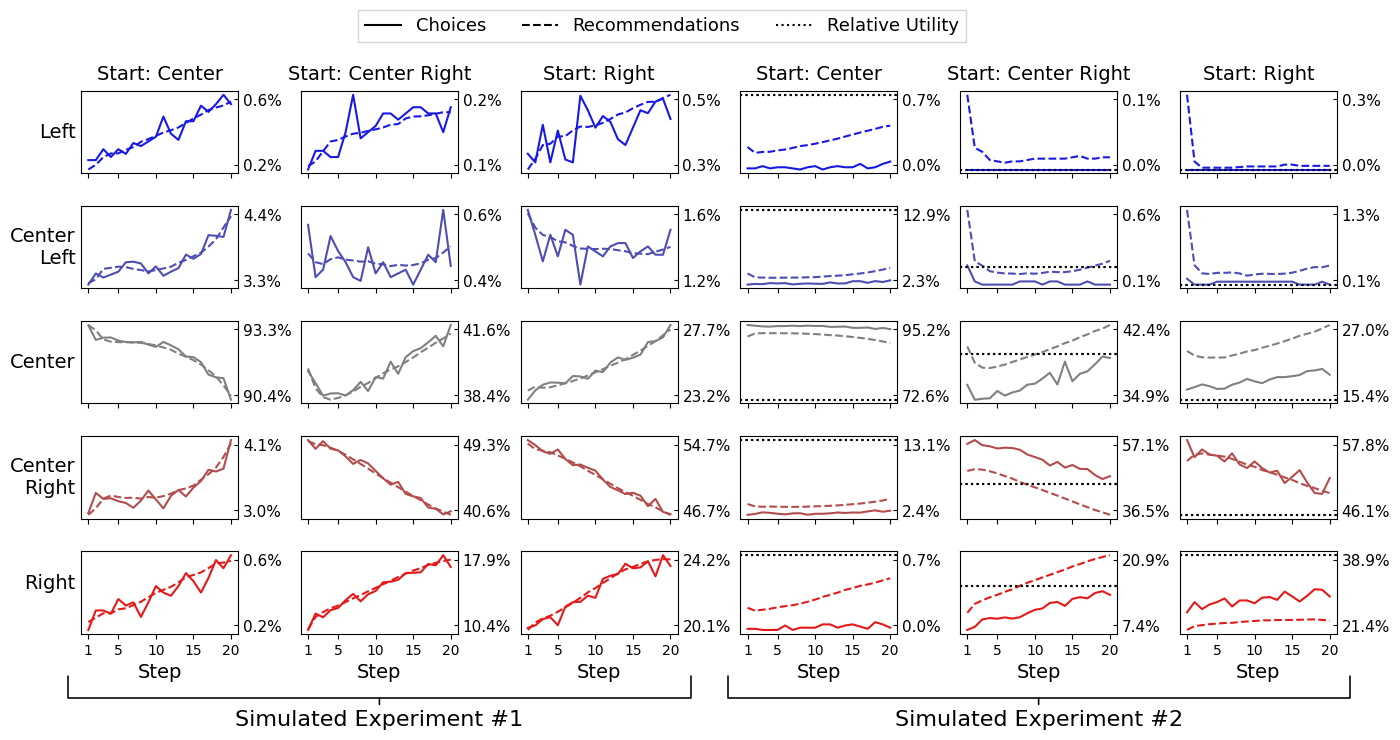

In [404]:
fig, axs_ = plt.subplots(5, 6, figsize=(14, 7.4), 
                         gridspec_kw={"hspace": 0.4, "wspace": 0.4}, 
                         sharex=True)

from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color="#000", lw=1.5),
                Line2D([0], [0], color="#000", lw=1.5, ls="--"),
               Line2D([0], [0], color="#000", lw=1.5, ls=":")]

axs_[0,3].legend(custom_lines, ['Choices', 'Recommendations', 'Relative Utility'], ncol=3, fontsize=13,
            loc='upper center', bbox_to_anchor=(-0.5, 2.1), fancybox=False, shadow=False)

vals_names = np.array(
    [['Start:C/Measure:L', 'Start:CR/Measure:L', 'Start:R/Measure:L',
        'User:C/Measure:L', 'User:CR/Measure:L', 'User:R/Measure:L'],
    ['Start:C/Measure:CL', 'Start:CR/Measure:CL', 'Start:R/Measure:CL',
        'User:C/Measure:CL', 'User:CR/Measure:CL', 'User:R/Measure:CL'],
    ['Start:C/Measure:C', 'Start:CR/Measure:C', 'Start:R/Measure:C',
        'User:C/Measure:C', 'User:CR/Measure:C', 'User:R/Measure:C'],
    ['Start:C/Measure:CR', 'Start:CR/Measure:CR', 'Start:R/Measure:CR',
        'User:C/Measure:CR', 'User:CR/Measure:CR', 'User:R/Measure:CR'],
    ['Start:C/Measure:R', 'Start:CR/Measure:R', 'Start:R/Measure:R',
        'User:C/Measure:R', 'User:CR/Measure:R', 'User:R/Measure:R']]
)

plt.annotate('Simulated Experiment #1', xy=(0.5, -0.75), xytext=(0.5, -1.05), xycoords=axs_[4, 1].transAxes, 
            fontsize=16, ha='center', va='center',
            arrowprops=dict(arrowstyle='-[, widthB=14.0, lengthB=1', lw=1.15))

plt.annotate('Simulated Experiment #2', xy=(0.5, -0.75), xytext=(0.5, -1.05), xycoords=axs_[4, 4].transAxes, 
            fontsize=16, ha='center', va='center',
            arrowprops=dict(arrowstyle='-[, widthB=14.0, lengthB=1', lw=1.15))

axs = {}

for i, j in zip(vals_names.flatten(), axs_.flatten()):
    axs[i] = j


color_map = {
    "C": "#808080",
    "CL" : "#4d4db3",
    "L": "#1919e6",
    "CR" : "#b34d4d",
    "R": "#e61919"
}

ls_map = {
    "recommendation": "--",
    "choice": "-",
}


for dfs, strv_t in zip([dfs3, dfs1], ["User:{}/Measure:{}", "Start:{}/Measure:{}"]):
    for start in ["C", "CR", "R"]:
        tmp_ = dfs[dfs.topic_start == start]
        for kind in ["recommendation", "choice"]:
            x = tmp_[tmp_.kind == kind].groupby(["idx", "label"]).count().idy.reset_index()
            x_norm = tmp_[tmp_.kind == kind].groupby(["idx"]).count().idy.reset_index()
            for measure in ["L", "CL", "C", "CR", "R"]:
                srtv = strv_t.format(start, measure)
                y = (x[x.label == measure].set_index("idx")/x_norm.set_index("idx")).fillna(0).idy

                axs[srtv].plot(y, color=color_map[measure], ls=ls_map[kind])
                lo, hi = axs[srtv].get_ylim()
                diff = (hi-lo) / 10
                axs[srtv].set_yticks([lo + diff, hi - diff])
                axs[srtv].set_yticklabels([
                    "{:.1%}". format(lo + diff),
                    "{:.1%}". format(hi - diff)
                ])

                if "User" in strv_t:
                    lower, upper = orie_to_low_hi[measure] 
                    prop = 0
                    sumprop = 0
                    
                    tmp__ =tmp_[(tmp_.kind == "choice") & (tmp_.idx == 0)]
                    
                    for useridx, idj in zip(tmp__.user_index,tmp__.sim):
                        prop += vals["matrices"][idj]["M"].X[useridx, lower:upper].sum()
                        sumprop += vals["matrices"][idj]["M"].X[useridx, :].sum()
                    hm =  prop/sumprop
                    axs[srtv].axhline(hm, lw=1.5, ls=":", color="black")
                    #print(start, measure, prop/sumprop)

axs_[0, 0].set_ylabel("Left", rotation=0, ha="right", size=14, va="center")
axs_[1, 0].set_ylabel("Center\nLeft", rotation=0, ha="right", size=14, va="center")
axs_[2, 0].set_ylabel("Center", rotation=0, ha="right", size=14, va="center")
axs_[3, 0].set_ylabel("Center\nRight", rotation=0, ha="right", size=14, va="center")
axs_[4, 0].set_ylabel("Right", rotation=0, ha="right", size=14)
axs_[0, 0].set_title("Start: Center", rotation=0, ha="center", size=14, pad=8)
axs_[0, 1].set_title("Start: Center Right", rotation=0, ha="center", size=14, pad=8)
axs_[0, 2].set_title("Start: Right", rotation=0, ha="center", size=14, pad=8)
axs_[0, 3].set_title("Start: Center", rotation=0, ha="center", size=14, pad=8)
axs_[0, 4].set_title("Start: Center Right", rotation=0, ha="center", size=14, pad=8)
axs_[0, 5].set_title("Start: Right", rotation=0, ha="center", size=14, pad=8)
axs_[4, 0].set_xlabel("Step", size=14)
axs_[4, 1].set_xlabel("Step", size=14)
axs_[4, 2].set_xlabel("Step", size=14)
axs_[4, 3].set_xlabel("Step", size=14)
axs_[4, 4].set_xlabel("Step", size=14)
axs_[4, 5].set_xlabel("Step", size=14)

for axx in axs_.flatten():
    axx.set_xticks([0, 4, 9, 14, 19])
    axx.set_xticklabels(["1", "5", "10", "15", "20"])
    axx.yaxis.tick_right()
    axx.tick_params(axis="y", direction='in', size=3, labelsize=11)
    

set_size(fig, (14, 7.4))
fig.savefig("experiment1.pdf", bbox_inches="tight")


In [277]:
orie_to_low_hi = {
    "L": (0, 75),
    "CL": (75, 200),
    "C": (200, 400),
    "CR": (400, 525),
    "R": (525, 600)
}

orie_to_user = {
    'L': 0,
    'CL': 140,
    'C': 300,
    'CR': 460,
    'R': 599
}
hm = np.zeros((3, 5))
for idx, start in enumerate(["C", "CR", "R"]):
        for idy, measure in enumerate(["L", "CL", "C", "CR", "R"]):
            lower, upper = orie_to_low_hi[measure] 
            useridx = orie_to_user[start]
            prop = 0
            sumprop = 0
            for idj in range(100):
                prop += vals["matrices"][idj]["M"].X[useridx, lower:upper].sum()
                sumprop += vals["matrices"][idj]["M"].X[useridx, :].sum()
            hm =  prop/sumprop
            print(start, measure, prop/sumprop)
#     plt.plot(vals["matrices"][1]["M"].X[item_to_user[lower], :])
#     plt.show()

C L 0.0010569592186017555
C CL 0.10526438980015064
C C 0.7859150215937533
C CR 0.10666791499754168
C R 0.0010957143899511094
CR L 2.0969863344666453e-07
CR CL 0.0036206207292501257
CR C 0.5036908506550654
CR CR 0.41328855229858946
CR R 0.07939976661846543
R L 5.225161928449271e-24
R CL 8.040492265696583e-11
R C 0.04123725198888548
R CR 0.43854172704412253
R R 0.5202210208865855


In [126]:
tmp_list_sizes

[0, 75, 200, 400, 525, 600]

In [308]:
hms, hss = [], []
for useridx in range(600):
    for idy, measure in enumerate(["CR"]):
            lower, upper = orie_to_low_hi[measure] 
            prop = 0
            sumprop = 0
            
            cons = 0
            sumcons = 0
            for idj in range(100):
                prop += vals["matrices"][idj]["M"].X[useridx, lower:upper].sum()
                sumprop += vals["matrices"][idj]["M"].X[useridx, :].sum()
                cons += vals["matrices"][idj]["S"].X[useridx, lower:upper].sum()
                sumcons += vals["matrices"][idj]["S"].X[useridx, :].sum()
            hm =  prop/sumprop
            hs =  cons/sumcons
            hms.append(hm)
            hss.append(hs)
            print(start, measure, prop/sumprop)

R CR 8.040492265696583e-11
R CR 4.020028088893518e-10
R CR 1.210991655082933e-09
R CR 2.842286970289536e-09
R CR 5.723591909809169e-09
R CR 1.037955423341653e-08
R CR 1.7436043674128325e-08
R CR 2.7624537873391695e-08
R CR 4.178660818615617e-08
R CR 6.087849905816782e-08
R CR 8.597579614320944e-08
R CR 1.1827817922935096e-07
R CR 1.5911425660712186e-07
R CR 2.0994647787160845e-07
R CR 2.723761223728516e-07
R CR 3.481483606692471e-07
R CR 4.391573864151228e-07
R CR 5.474516161553238e-07
R CR 6.752389545068436e-07
R CR 8.248921221965634e-07
R CR 9.98954044410892e-07
R CR 1.2001432968550477e-06
R CR 1.4313596068999945e-06
R CR 1.6956894071602626e-06
R CR 1.996411438737162e-06
R CR 2.337002401384042e-06
R CR 2.7211426477789072e-06
R CR 3.1527219189621913e-06
R CR 3.6358451180852924e-06
R CR 4.174838119457968e-06
R CR 4.774253609842017e-06
R CR 5.438876958950986e-06
R CR 6.173732116072578e-06
R CR 6.98408752954281e-06
R CR 7.875462086034535e-06
R CR 8.853631066282135e-06
R CR 9.924632114101

R CR 0.25742273103820035
R CR 0.259540077858744
R CR 0.2616606377456009
R CR 0.26378422333644536
R CR 0.26591064499507255
R CR 0.2680397108136966
R CR 0.2701712266149304
R CR 0.2723049959551085
R CR 0.2744408201265213
R CR 0.2765784981625837
R CR 0.2787178268410542
R CR 0.28085860069054785
R CR 0.28300061199431037
R CR 0.2851436507986889
R CR 0.2872875049184094
R CR 0.28943195994560544
R CR 0.2915767992574022
R CR 0.2937218040253084
R CR 0.2958667532254836
R CR 0.2980114236493762
R CR 0.3001555899152501
R CR 0.3022990244804362
R CR 0.30444149765551864
R CR 0.3065827776174963
R CR 0.30872263042585263
R CR 0.3108608200380677
R CR 0.3129971083272786
R CR 0.3151312551002331
R CR 0.31726301811656527
R CR 0.31939215310887553
R CR 0.32151841380465457
R CR 0.32364155194876576
R CR 0.325761317326287
R CR 0.32787745778817956
R CR 0.3299897192781914
R CR 0.33209784585858965
R CR 0.33420157974024817
R CR 0.3363006613115744
R CR 0.33839482917071095
R CR 0.3404838201583088
R CR 0.34256736939040866
R

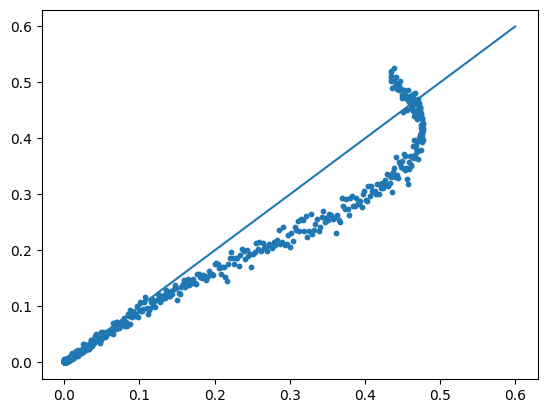

In [309]:
plt.scatter(hms, hss, s=10)
plt.plot([0.0, 0.6], [0, 0.6])

In [332]:
user_index = np.random.randint(0,600)
tmp_list_sizes = np.array([0] + list(vals["parameters"]["list_sizes"].cumsum()))

maxval = S.X[user_index, :].argmax()
argmaxval = (tmp_list_sizes >= maxval).argmax()
lower, upper = tmp_list_sizes[argmaxval - 1], tmp_list_sizes[argmaxval]

print(maxval, tmp_list_sizes[argmaxval - 1], tmp_list_sizes[argmaxval])
tmp_list_sizes >= maxval, tmp_list_sizes, (tmp_list_sizes >= maxval).argmax()

206 200 400


(array([False, False, False,  True,  True,  True]),
 array([  0,  75, 200, 400, 525, 600]),
 3)

# Old experiment 2

In [284]:
recompute = True
item_to_user = {
    0: 0,
    75: 180,
    200: 300,
    400: 420,
    525: 599
}

if recompute:
    dfs = []
    for sim in tqdm(range(100)):
        tmp = vals["matrices"][sim]
        M, S = tmp["M"], tmp["S"]
        tmp_list_sizes = [0] + list(vals["parameters"]["list_sizes"].cumsum())
        for lower, upper in zip(tmp_list_sizes[:-1], tmp_list_sizes[1:]):
            for i in range(100):
                to_add = [np.random.randint(lower, upper)]
                topic_start = map_index_to_topic(to_add[0], vals["parameters"]["list_sizes"])
                df = measure_1_round(
                    M=M, 
                    S=S, 
                    to_add=to_add, 
                    list_sizes=vals["parameters"]["list_sizes"], 
                    z=20, 
                    user_index=item_to_user[lower], 
                    selection_mode="utility"
                )
                df["idy"] = i
                df["sim"] = sim
                df["topic_start"] = topic_start
                dfs.append(df)
    dfs2 = pd.concat(dfs)
    dfs2.to_csv("df_exp2.csv.gz", index=False)
else:
    dfs2 = pd.read_csv("df_exp2.csv.gz")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [22:57<00:00, 13.77s/it]
